In [1]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
inp0 = pd.read_csv('AAPL.csv')
inp0.head()

,Date,Close,Open,High,Low,Volume
0,1/17/2020,138.31,136.54,138.330,136.16,5623336
1,1/16/2020,137.98,137.32,138.190,137.01,4320911
2,1/15/2020,136.62,136.00,138.055,135.71,4045952
3,1/14/2020,135.82,136.28,137.139,135.55,3683458
4,1/13/2020,136.60,135.48,136.640,135.07,3531572


In [3]:
inp0.tail()

,Date,Close,Open,High,Low,Volume
2509,1/29/2010,122.39,124.32,125.000,121.90,11571890
2510,1/28/2010,123.75,127.03,127.040,123.05,9616132
2511,1/27/2010,126.33,125.82,126.960,125.04,8719147
2512,1/26/2010,125.75,125.92,127.750,125.41,7135190
2513,1/25/2010,126.12,126.33,126.895,125.71,5738455


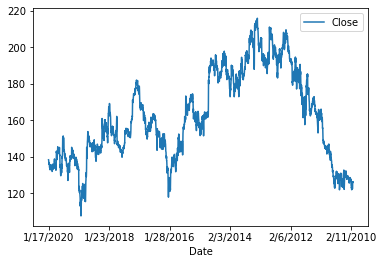

In [4]:
inp0.plot("Date", "Close")
plt.show()

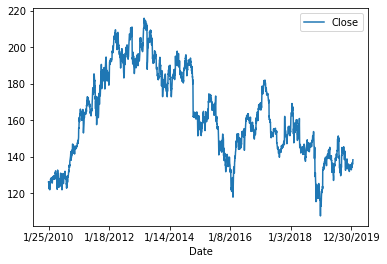

In [5]:
inp0 = inp0.sort_index(ascending=False)
inp0.plot("Date", "Close")
plt.show()

In [6]:
ts_data = inp0.Close.values.reshape(-1, 1)
ts_data

array([[126.12],
       [125.75],
       [126.33],
       ...,
       [136.62],
       [137.98],
       [138.31]])

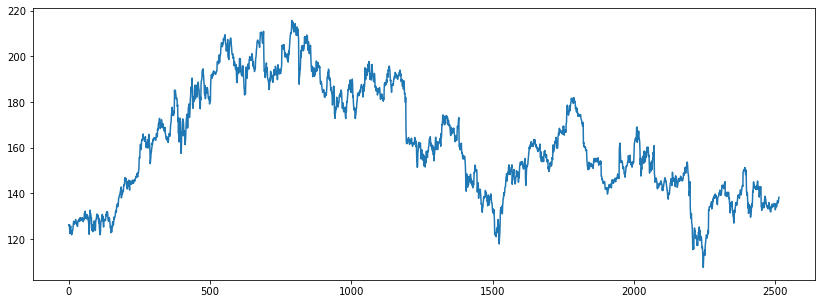

In [7]:
plt.figure(figsize=[14, 5])
plt.plot(ts_data)
plt.show()

In [8]:
train_recs = int(len(ts_data) * 0.75)
print(train_recs)

1885


In [9]:
train_data = ts_data[:train_recs]
test_data = ts_data[train_recs:]
len(train_data), len(test_data)

(1885, 629)

In [10]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.fit_transform(test_data)

In [11]:
def get_lookback(inp, look_back):
    y = pd.DataFrame(inp)
    dataX = [y.shift(i) for i in range(1, look_back+1)]
    dataX = pd.concat(dataX, axis=1)
    dataX.fillna(0, inplace=True)
    return dataX.values, y.values

In [12]:
look_back = 10
trainX, trainY = get_lookback(train_scaled, look_back)
testX, testY = get_lookback(test_scaled, look_back)

In [13]:
trainX.shape, testX.shape

((1885, 10), (629, 10))

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, \
    Activation, Dropout, Dense, Reshape


In [15]:
model = Sequential()

In [16]:
model.add(
    Reshape(
        (look_back, 1), input_shape=(look_back,)
    )
)
model.add(
    SimpleRNN(
        32, input_shape=(look_back, 1)
    )
)
model.add(Dense(1))
model.add(Activation('linear'))

In [17]:
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 10, 1)             0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 32)                1088      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
_________________________________________________________________
activation (Activation)      (None, 1)                 0         
Total params: 1,121
Trainable params: 1,121
Non-trainable params: 0
_________________________________________________________________


Implementing forward pass of a simple RNN

In [18]:
import numpy as np
import tensorflow as tf
np.random.seed(0)
tf.random.set_seed(0)

In [19]:
num_inputs = 2
num_neurons = 3

In [20]:
Wf = tf.Variable(
    tf.random.normal(
        shape=[num_inputs, num_neurons]
    )
)
Wr = tf.Variable(
    tf.random.normal(
        shape=[num_neurons, num_neurons]
    )
)

In [21]:
b = tf.Variable(tf.zeros([1, num_neurons]))
b

<tf.Variable 'Variable:0' shape=(1, 3) dtype=float32, numpy=array([[0., 0., 0.]], dtype=float32)>

In [22]:
xt0_batch = np.array([
    [0,1], [2,3], [4,5]
]).astype(np.float32)
xt1_batch = np.array([
    [100, 101], [102, 103], [104, 105]
]).astype(np.float32)

In [23]:
def forward_pass(xt0, xt1):
    yt0 = tf.tanh(tf.matmul(xt0, Wf) + b)
    yt1 = tf.tanh(tf.matmul(yt0, Wr) + tf.matmul(xt1, Wf) + b)
    return yt0, yt1


In [24]:
yt0_output, yt1_output = forward_pass(xt0_batch, xt1_batch)


In [25]:
tf.print(yt0_output)

[[-0.776318431 -0.844548523 0.438419849]
 [-0.0857753083 -0.993522227 0.516408086]
 [0.698345542 -0.999749541 0.586677969]]


In [26]:
tf.print(yt1_output)


[[1 -1 0.999998629]
 [1 -1 0.999998331]
 [1 -1 0.999997199]]


Preparing the data for stock price prediction

In [27]:
train_recs = int(len(ts_data) * 0.75)
train_recs


1885

In [28]:
train_data = ts_data[:train_recs]
test_data = ts_data[train_recs:]


In [29]:
len(train_data), len(test_data)


(1885, 629)

In [30]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)

In [31]:
def get_lookback(inp, look_back):
    y = pd.DataFrame(inp)
    dataX = [y.shift(i) for i in range(1, look_back+1)]
    dataX = pd.concat(dataX, axis=1)
    dataX.fillna(0, inplace=True)
    return dataX.values, y.values


In [32]:
look_back = 10
trainX, trainY = get_lookback(train_scaled, look_back=look_back)
testX, testY = get_lookback(test_scaled, look_back=look_back)


In [33]:
trainX.shape, testX.shape


((1885, 10), (629, 10))

Building a RNN model

In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Activation, Dropout, Dense, Reshape


In [35]:
model = Sequential()
model.add(Reshape((look_back, 1), input_shape=(look_back,)))
model.add(SimpleRNN(32, input_shape=(look_back, 1)))
model.add(Dense(1))
model.add(Activation('linear'))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 10, 1)             0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 32)                1088      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 1,121
Trainable params: 1,121
Non-trainable params: 0
_________________________________________________________________


Model Training and Performance Evaluation

In [36]:
model.fit(trainX, trainY, epochs=3, batch_size=1, verbose=2, validation_split=0.1)

Epoch 1/3
1696/1696 - 21s - loss: 0.0037 - val_loss: 5.5507e-04
Epoch 2/3
1696/1696 - 19s - loss: 0.0012 - val_loss: 5.2944e-04
Epoch 3/3
1696/1696 - 18s - loss: 0.0011 - val_loss: 4.1913e-04


In [37]:
import math
def get_model_perf(model_obj):
    score_train = model_obj.evaluate(trainX, trainY, verbose=0)
    print('Train RMSE: %.2f RMSE' % (math.sqrt(score_train)))
    score_test = model_obj.evaluate(testX, testY, verbose=0)
    print('Test RMSE: %.2f RMSE' % (math.sqrt(score_test)))

In [38]:
get_model_perf(model)

Train RMSE: 0.02 RMSE
Test RMSE: 0.03 RMSE


In [39]:
def plot_pred(model_obj):
    testPredict = scaler.inverse_transform(model_obj.predict(testX))
    pred_test_plot = ts_data.copy()
    pred_test_plot[:train_recs + look_back, :] = np.nan
    pred_test_plot[train_recs + look_back:, :] = testPredict[look_back:]
    plt.plot(ts_data)
    plt.plot(pred_test_plot, "--")

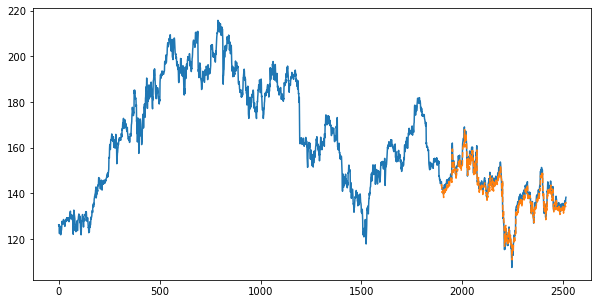

In [40]:
%matplotlib inline
plt.figure(figsize=[10, 5])
plot_pred(model)

Building a 1D Convolution-based model

In [41]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten

In [42]:
model_conv = Sequential()
model_conv.add(Reshape((look_back, 1), input_shape=(look_back,)))
model_conv.add(Conv1D(filters=5, kernel_size=5, activation='relu'))
model_conv.add(MaxPooling1D(pool_size=5))
model_conv.add(Flatten())
model_conv.add(Dense(1))
model_conv.add(Activation('linear'))
model_conv.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 10, 1)             0         
_________________________________________________________________
conv1d (Conv1D)              (None, 6, 5)              30        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1, 5)              0         
_________________________________________________________________
flatten (Flatten)            (None, 5)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6         
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total params: 36
Trainable params: 36
Non-trainable params: 0
__________________________________________________________

In [43]:
model_conv.compile(loss='mean_squared_error', optimizer='adam')
model_conv.fit(
    trainX,
    trainY,
    epochs=5,
    batch_size=1,
    verbose=2,
    validation_split=0.1)


Epoch 1/5
1696/1696 - 40s - loss: 0.0457 - val_loss: 0.0013
Epoch 2/5
1696/1696 - 5s - loss: 0.0023 - val_loss: 0.0012
Epoch 3/5
1696/1696 - 5s - loss: 0.0022 - val_loss: 0.0013
Epoch 4/5
1696/1696 - 5s - loss: 0.0021 - val_loss: 0.0012
Epoch 5/5
1696/1696 - 5s - loss: 0.0020 - val_loss: 0.0010


In [44]:
get_model_perf(model_conv)

Train RMSE: 0.04 RMSE
Test RMSE: 0.05 RMSE


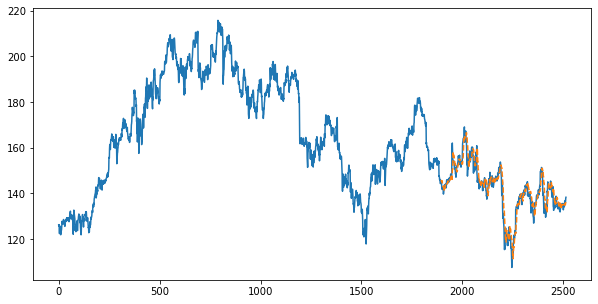

In [45]:
%matplotlib inline
plt.figure(figsize=[10, 5])
plot_pred(model_conv)

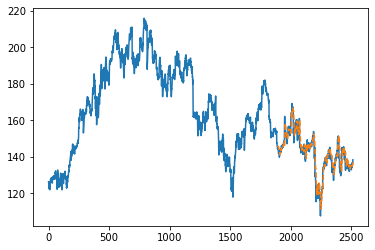

In [47]:
%matplotlib inline
plot_pred(model_conv)

Building a hybrid (1D Convolution-based + RNN) model

In [48]:
model_comb = Sequential()
model_comb.add(Reshape((look_back, 1), input_shape=(look_back,)))
model_comb.add(Conv1D(filters=5, kernel_size=3, activation='relu'))
model_comb.add(SimpleRNN(32))
model_comb.add(Dense(1))
model_comb.add(Activation('linear'))
model_comb.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_3 (Reshape)          (None, 10, 1)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 8, 5)              20        
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 32)                1216      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
_________________________________________________________________
activation_3 (Activation)    (None, 1)                 0         
Total params: 1,269
Trainable params: 1,269
Non-trainable params: 0
_________________________________________________________________


In [50]:
model_comb.compile(loss='mean_squared_error', optimizer='adam')
model_comb.fit(
    trainX,
    trainY,
    epochs=3,
    batch_size=1,
    verbose=2,
    validation_split=0.1)

Epoch 1/3
1696/1696 - 29s - loss: 0.0028 - val_loss: 5.2674e-04
Epoch 2/3
1696/1696 - 26s - loss: 0.0013 - val_loss: 6.8441e-04
Epoch 3/3
1696/1696 - 26s - loss: 0.0012 - val_loss: 5.2875e-04


In [51]:
get_model_perf(model_comb)

Train RMSE: 0.03 RMSE
Test RMSE: 0.04 RMSE


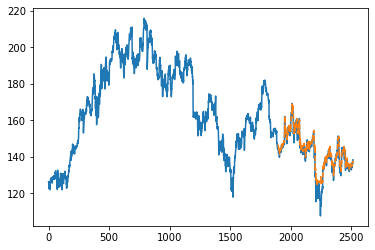

In [52]:
plot_pred(model_comb)

Using a plain RNN model to predict IBM stock prices

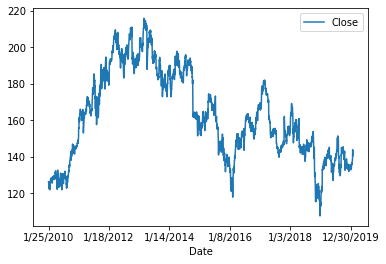

In [53]:
inp0 = pd.read_csv("IBM.csv")
inp0 = inp0.sort_index(ascending=False)
inp0.plot("Date", "Close")
plt.show()

In [54]:
ts_data = inp0.Close.values.reshape(-1, 1)

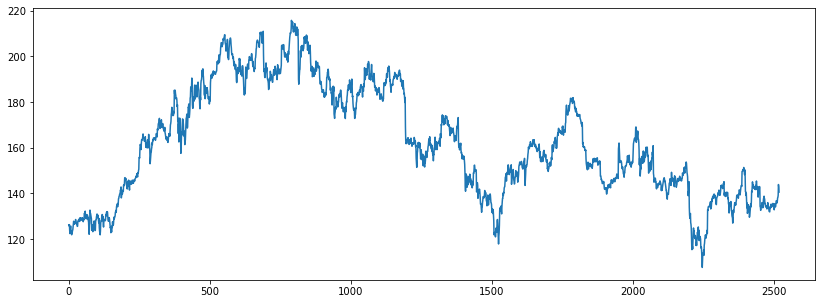

In [55]:
plt.figure(figsize=[14, 5])
plt.plot(ts_data)
plt.show()

In [56]:
# assign the final 25% data as test data, first 75% as train
train_recs = int(len(ts_data) * 0.75)
train_data = ts_data[:train_recs]
test_data = ts_data[train_recs:]

In [57]:
len(train_data), len(test_data)

(1888, 630)

In [58]:
# Using MinMaxScaler from sklearn to scale the train and test data
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)

In [59]:
look_back = 10
trainX, trainY = get_lookback(train_scaled, look_back=look_back)
testX, testY = get_lookback(test_scaled, look_back=look_back)

In [60]:
trainX.shape, testX.shape

((1888, 10), (630, 10))

In [64]:
model_comb = Sequential()
model_comb.add(Reshape((look_back, 1), input_shape=(look_back,)))
model_comb.add(Conv1D(filters=5, kernel_size=3, activation='relu'))
model_comb.add(SimpleRNN(32))
model_comb.add(Dropout(0.25))
model_comb.add(Dense(1))
model_comb.add(Activation('linear'))
model_comb.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_7 (Reshape)          (None, 10, 1)             0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 8, 5)              20        
_________________________________________________________________
simple_rnn_6 (SimpleRNN)     (None, 32)                1216      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
_________________________________________________________________
activation_4 (Activation)    (None, 1)                 0         
Total params: 1,269
Trainable params: 1,269
Non-trainable params: 0
____________________________________________________

In [65]:
model_comb.compile(loss='mean_squared_error', optimizer='adam')
model_comb.fit(
    trainX,
    trainY,
    epochs=5,
    batch_size=1,
    verbose=2,
    validation_split=0.1)

Epoch 1/5
1699/1699 - 31s - loss: 0.0086 - val_loss: 6.6204e-04
Epoch 2/5
1699/1699 - 26s - loss: 0.0042 - val_loss: 4.4425e-04
Epoch 3/5
1699/1699 - 29s - loss: 0.0031 - val_loss: 4.9686e-04
Epoch 4/5
1699/1699 - 28s - loss: 0.0024 - val_loss: 3.8670e-04
Epoch 5/5
1699/1699 - 26s - loss: 0.0022 - val_loss: 3.9659e-04


In [66]:
get_model_perf(model_comb)

Train RMSE: 0.03 RMSE
Test RMSE: 0.04 RMSE


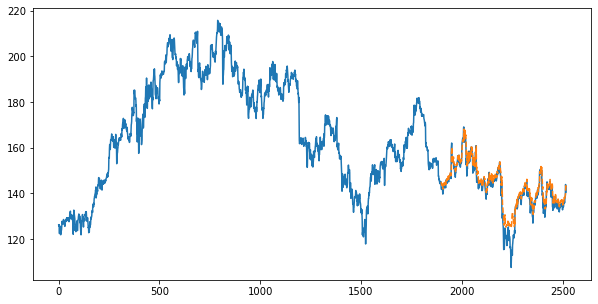

In [67]:
plt.figure(figsize=[10, 5])
plot_pred(model_comb)